# An Architecture Combining Convolutional Neural Network (CNN) and Support Vector Machine (SVM) for Image Classification
---

여기서부터는, 위 논문에서 제시한 CNN의 마지막 layer로 softmax 대신 SVM을 사용하는 model을 구현해보도록 하겠습니다. 

data는 논문과 같이 Fashion MNIST를 사용하였습니다. data size는 train, test 각 60000, 10000이며, 하나의 instance는 28x28 pixel값을 가지고, 이미지에 나와있는 의류 class를 label로 가집니다. 

다음과 같은 순서로 진행하겠습니다. 

0. Data Loading
1. CNN using softmax
2. CNN using SVM
3. 각 model train 후, 평가

---
## 0. Data Loading

In [64]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torch.utils.data import Dataset
from torch.autograd import Variable
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# random seed 고정
torch.manual_seed(923)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(923)

### Fashion MNIST Data load
논문과 동일하게 batch size=128로 data_loader 생성

In [66]:
batch_size = 128

In [67]:
root = './fashion-mnist/data/fashion/'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dsets.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dsets.FashionMNIST(root=root, train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [68]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fashion-mnist/data/fashion/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [69]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./fashion-mnist/data/fashion/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

### Visualization
image class는 의류 종류로, 다음과 같이 총 10개의 class가 존재합니다. 

In [70]:
classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal',
           'Shirt','Sneaker','Bag','Ankle Boot')

In [71]:
ex_train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)
ex_test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, drop_last=True)

이미지 data와 그 label을 살펴보겠습니다. 

torch.Size([16, 1, 28, 28])
torch.Size([16])


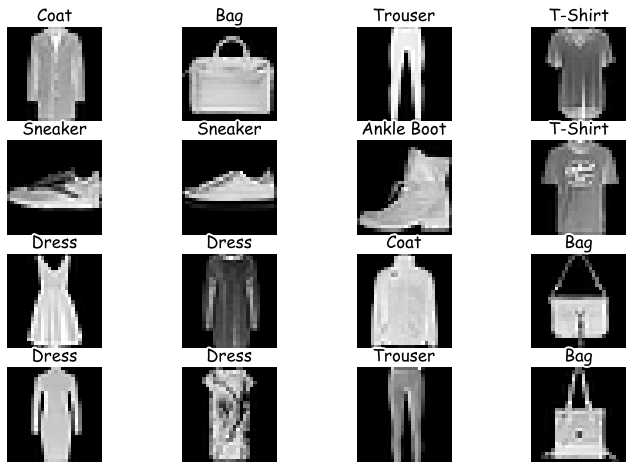

In [72]:
for batch_1 in ex_train_loader:
    batch = batch_1
    break

print(batch[0].shape) # as batch[0] contains the image pixels -> tensors
print(batch[1].shape) # batch[1] contains the labels -> tensors


plt.figure(figsize=(12, 8))
for i in range (batch[0].shape[0]):
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.imshow(batch[0][i].reshape(28, 28), cmap='gray')
    plt.title(classes[batch[1][i]])
    #plt.savefig('fashion_mnist.png')
plt.show()

위와 같이 하나의 instance는 image와 label로 이루어져 있습니다.

### Hyper-parameter 설정
논문에서 제시한 learning rate와 batch size를 설정했습니다. 
논문에서 수행한 epoch=10000이지만 수행 시간이 매우 긴 관계로 epoch=100으로 설정하겠습니다. 

In [73]:
learning_rate = 0.001
training_epochs = 15
batch_size = 128

### CNN architecture
CNN architucture는 다음과 같습니다. 위에 제시한 표와 같이 논문에서 언급한 구조 그대로 구현하였습니다. 이 구조는 CNN-softmax와 CNN-SVM에서 공통적으로 사용됩니다. 단, CNN-softmax에서는 마지막 fully-connected layer에 softmax를 취하고, CNN-SVM에서는 fully-connected layer를 hyperplane으로 보고, 이에 대한 margin을 최대화 하는 hinge loss function을 사용하여 update합니다. 

In [74]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5


        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 27, 27, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=1))


        # L2 ImgIn shape=(?, 27, 27, 32)
        #    Conv      ->(?, 27, 27, 64)
        #    Pool      ->(?, 26, 26, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=1))


        # L3 FC 26x26x64 inputs -> 1024 outputs
        self.fc1 = torch.nn.Linear(26 * 26 * 64, 1024, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.Dropout(p=1 - self.keep_prob))


        # L4 Final FC 1024 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(1024, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)



    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer3(out)
        out = self.fc2(out)
        return out

# 1. Convolution Neural Network with Softmax
CNN-softmax는 위에서 정의한 CNN 구조를 사용하며, loss function은 CrossEntropy를 사용합니다. 

In [75]:
# CNN 모델 정의
model_softmax= CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model_softmax.parameters(), lr=learning_rate)

total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 468


## Train
epoch=100번에 대해 학습을 진행합니다.loss변화를 확인하기 위해 각 epoch마다 loss를 loss_in_each_epoch 저장하였습니다. 

In [76]:
loss_in_each_epoch = []
for epoch in range(training_epochs):
    total_loss = 0

    for X, Y in train_loader: # mini batch 단위로 data 불러옴
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)


        optimizer.zero_grad()
        output = model_softmax(X)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()

        total_loss += loss

    avg_loss = total_loss/total_batch
    loss_in_each_epoch.append(avg_loss)
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_loss))

[Epoch:    1] cost = 0.669426799
[Epoch:    2] cost = 0.365033686
[Epoch:    3] cost = 0.326559991
[Epoch:    4] cost = 0.310010195
[Epoch:    5] cost = 0.290988356
[Epoch:    6] cost = 0.276276618
[Epoch:    7] cost = 0.269960195
[Epoch:    8] cost = 0.25954327
[Epoch:    9] cost = 0.255108505
[Epoch:   10] cost = 0.250736773
[Epoch:   11] cost = 0.243994385
[Epoch:   12] cost = 0.242512524
[Epoch:   13] cost = 0.234006956
[Epoch:   14] cost = 0.230456144
[Epoch:   15] cost = 0.225855112


학습을 반복하면 다음과 같이 loss가 줄어들게 됩니다. 15번에 가깝게 수행할수록 loss는 0에 가까워집니다. 

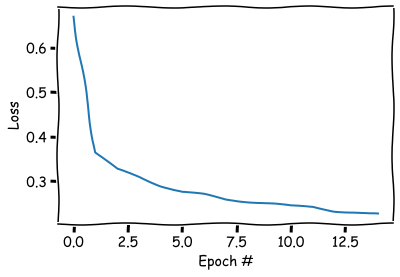

In [77]:
plt.xkcd()
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(loss_in_each_epoch)
plt.show()

## Test
test data를 batch 단위로 불러와 전체 평균 accuracy를 계산하였습니다

In [78]:
with torch.no_grad():
    correct = 0
    total = 0
    batch_X = []
    batch_Y = []
    predicted_softmax = []
    
    for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        prediction = model_softmax(X_test)
        predicted = torch.argmax(prediction, 1)
        total += Y_test.size(0)
        correct += (predicted == Y_test).sum().item()
        
        batch_X.append(X_test)
        batch_Y.append(Y_test)
        predicted_softmax.append(predicted)

accuracy_softmax =100*correct/total
print('Test Accuracy of the model on the 10000 test images: {} %'.format(accuracy_softmax))

Test Accuracy of the model on the 10000 test images: 89.13261217948718 %


## Test accuracy
epoch=100일 때 CNN-softmax의 accuracy는 89.14%정도로 나왔습니다.

## 결과 확인
하나의 batch에 대해서 classification 결과를 확인해보도록 하겠습니다. 128개의 example에 대해 각 이미지와 label을 아래와 같이 출력하였습니다. 

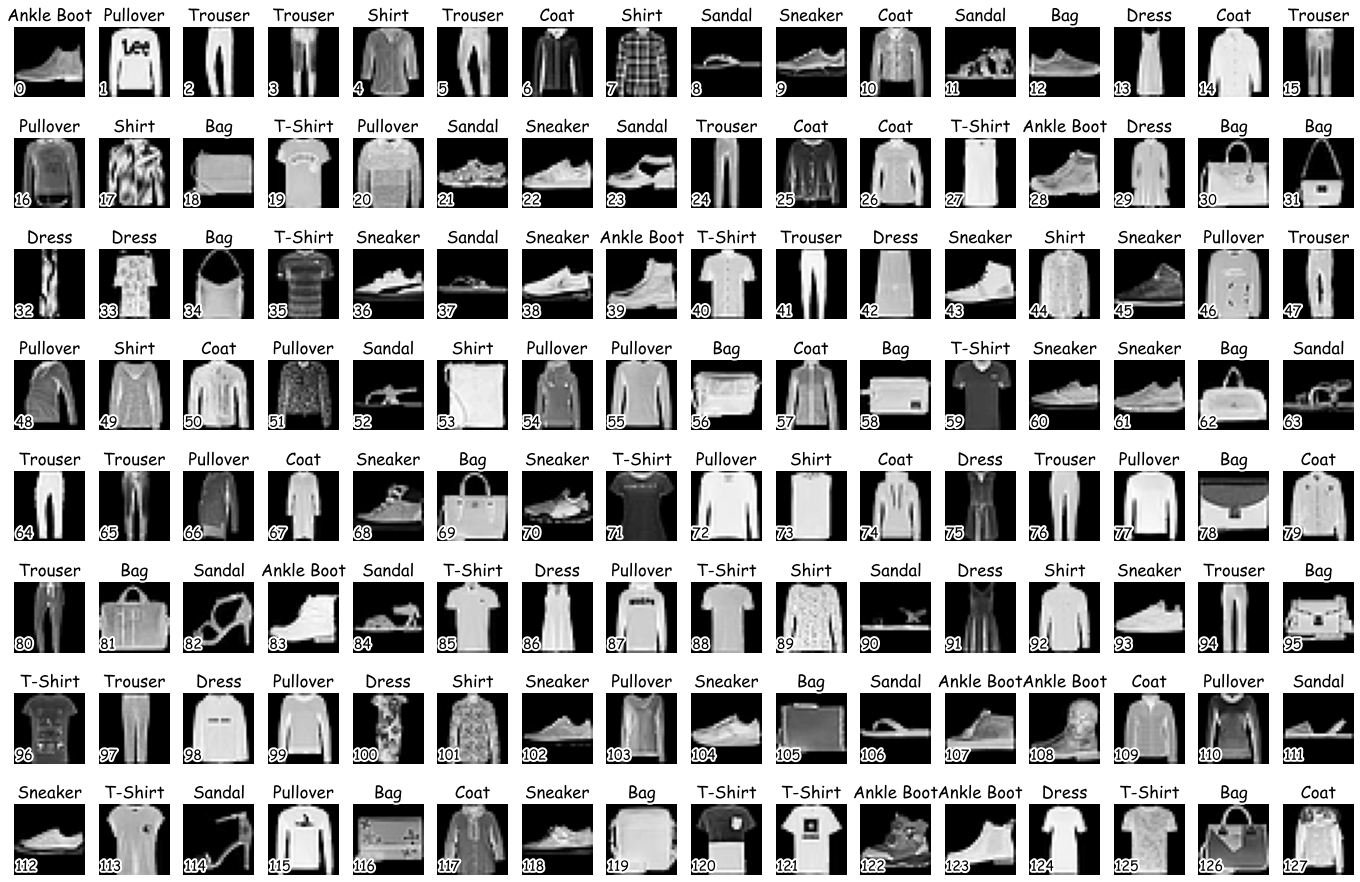

In [79]:
plt.figure(figsize=(24, 16))
for i in range(len(batch_X[0])): 
    plt.subplot(8, len(batch_X[0])/8, i+1)
    plt.axis('off')
    plt.imshow(batch_X[0][i].cpu().reshape(28, 28), cmap='gray')
    plt.title(classes[predicted_softmax[0][i]])
    plt.text(0, 26,i)
#plt.savefig('fashion_mnist.png')
plt.show()

- 0번 ankle boot 이미지에 대해서 ankle boot로 잘 분류한 것을 확인할 수 있습니다. 
- 22번도 sneaker를 잘 분류했습니다.
- 이 외에도 거의 대부분의 example에 대해 맞게 분류하고 있습니다.  

하지만 91번 dress 이미지를 T-shirt로 분류한 것처럼 오분류 결과가 존재합니다. 이들만 따로 출력해 확인해보도록 하겠습니다. 

### Misclassification 확인
위와 같은 분류 결과 중, 오분류한 결과만을 출력해보겠습니다.   
(A:Actual label, P:Predicted label)

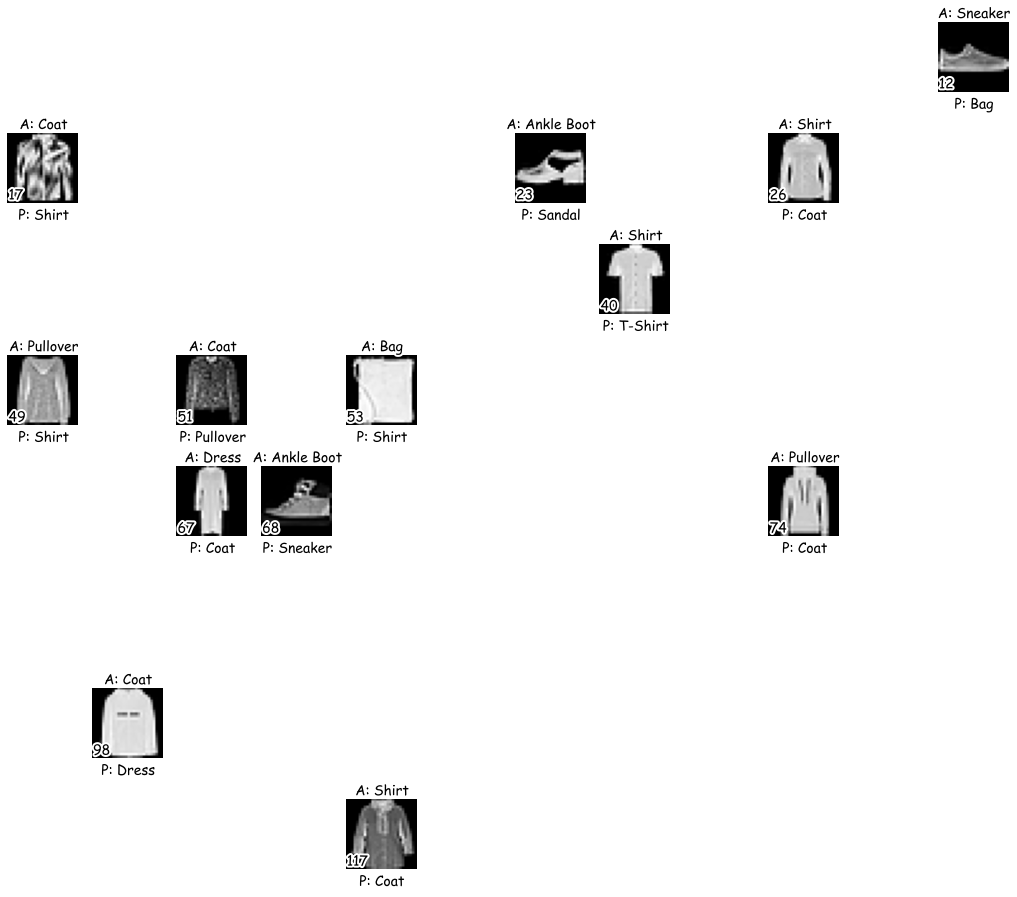

In [80]:
plt.figure(figsize=(24, 16))
for i in range(len(batch_X[0])): 
    if predicted_softmax[0][i] !=batch_Y[0][i]:
        plt.subplot(8, len(batch_X[0])/8, i+1)
        plt.axis('off')
        plt.imshow(batch_X[0][i].cpu().reshape(28, 28), cmap='gray')
        plt.text(14, -2,'A: '+classes[batch_Y[0][i]], ha='center')
        plt.text(0, 26,i)
        plt.text(14, 34,'P: '+classes[predicted_softmax[0][i]], ha='center')
    #plt.savefig('fashion_mnist.png')
plt.show()

앞서 언급한 91번 dress 외에도 12번 example은 sneaker를 sandal로 분류하고, 32번 example은 dress를 bag으로 분류하는 등 128개 중 14개의 example에 대해 오분류되었습니다. 잘못 분류된 example들을 보면 그렇지 않은 경우도 있지만, 이미지 자체가 사람이 판단하기에도 애매한 부분이 있습니다.  


다음은 classifier로 SVM을 사용하는 CNN을 구현해보도록 하겠습니다. 

# 2. Convolution Neural Network with Support Vector Machine
CNN-softmax는 위에서 정의한 CNN 구조를 사용하며, SVM은 목적식을 minimize하면서 optimal hyperplane을 찾기 때문에 loss function으로는 SVM의 목적식을 사용합니다. 

## Support Vector Machine Loss Function
- HingeLoss
SVM의 목적식은 ${minimize} \ {L({\bf w},C)}=\bf{w}^T\bf{w}+C\sum_{i=1}^m {max} (0, 1-y_i'({\bf x}_i^T{\bf w}))^2$으로, max fuinction에 의해 0 이상의 값은 그대로, 0 이하의 값은 0으로 수렴하게 해, 이 모양을 본따 hinge loss라고 합니다. 

### 2-1. With $\mathbf{w}^T\mathbf{w}$ minimization
${minimize} \ {L({\bf w},C)}=\bf{w}^T\bf{w}+C\sum_{i=1}^m {max} (0, 1-y_i'({\bf x}_i^T{\bf w}))^2$에 대한 목적식을 loss function으로 구현한 결과는 다음과 같습니다. max function term에 대해 계산 뒤, $\mathbf{w}^T\mathbf{w}$의 크기를 loss에 더해주었습니다. 

In [117]:
class multiClassHingeLoss_gen(nn.Module):
    def __init__(self):
        super(multiClassHingeLoss_gen, self).__init__()
    
    def forward(self, output, y, fc):#output: batchsize*n_class
        
        output_y=output[torch.arange(0,y.size()[0]).long().cuda(),y.data.cuda()]
               
        #loss = torch.zeros([128, 10]).cuda()
        loss=output
        loss[loss!=0] = 0
        loss[torch.arange(0,y.size()[0]).long().cuda(),y.data.cuda()] = 1-output_y
        
        #max(0,_)
        loss[loss<0]=0

        #L2-SVM
        loss=torch.pow(loss,2)

        # w^tw
        loss = torch.sum(loss) + torch.pow(fc, 2).sum()
        loss/=output.size()[0]
        
        return loss, torch.pow(fc, 2).sum()

이제 여기서부터는 CNN-softmax와 같이 epoch=100번 학습시키고 이에 대한 결과를 확인해보도록 하겠습니다.

## Train
epoch=100번에 대해 학습을 진행합니다.loss변화를 확인하기 위해 각 epoch마다 loss를 loss_in_each_epoch 저장하였습니다. 

In [118]:
# CNN 모델 정의
model_SVM_gen = CNN().to(device)

criterion = multiClassHingeLoss_gen().to(device)   
optimizer = torch.optim.Adam(model_SVM_gen.parameters(), lr=learning_rate)

total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 468


In [119]:
loss_in_each_epoch = []
wtw_in_each_epoch = []
for epoch in range(training_epochs):
    total_loss = 0
    total_wtw = 0
    
    for X, Y in train_loader: 
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        output = model_SVM_gen(X)
        loss, wtw = criterion(output, Y, model_SVM_gen.fc2.weight.data)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        total_wtw += wtw.item()
         
    avg_loss = total_loss/total_batch
    loss_in_each_epoch.append(avg_loss)
    avg_wtw = total_wtw/total_batch
    wtw_in_each_epoch.append(avg_wtw)
    print('[Epoch: {:>4}] loss = {:>.9}, weight = {:>.9}'.format(epoch + 1, avg_loss, avg_wtw))

RuntimeError: CUDA out of memory. Tried to allocate 170.00 MiB (GPU 0; 11.00 GiB total capacity; 3.19 GiB already allocated; 21.18 MiB free; 3.21 GiB reserved in total by PyTorch)

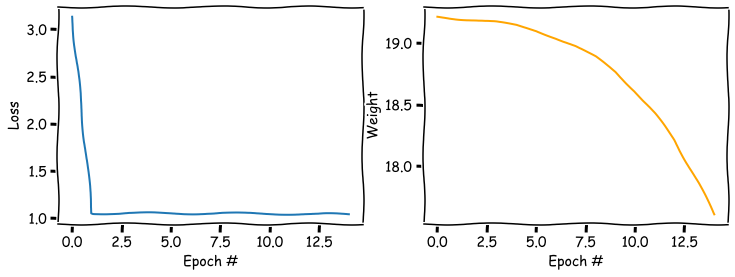

In [90]:
plt.xkcd()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(loss_in_each_epoch)


plt.subplot(1, 2, 2)
plt.xlabel('Epoch #')
plt.ylabel('Weight')
plt.plot(wtw_in_each_epoch, color='orange')
plt.show()

loss는 epoch을 돌수록 0에 수렴하고, 마지막 fully-connected layer의 weight 값이 점점 감소하다가 일정 epoch 이후 증가함을 확인할 수 있습니다. weight의 크기는 epoch=17일 때 가장 작은 것으로 확인되었습니다. 이에 대해서는 아래에서 다시 언급하도록 하겠습니다. 

## Test
test도 CNN-softmax와 같은 방법으로 진행했습니다. 

In [46]:
with torch.no_grad():
    correct = 0
    total = 0
    batch_X = []
    batch_Y = []
    predicted_SVM_gen = []
    
    for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        prediction = model_SVM_gen(X_test)
        predicted = torch.argmax(prediction, 1)
        total += Y_test.size(0)
        correct += (predicted == Y_test).sum().item()
        
        batch_X.append(X_test)
        batch_Y.append(Y_test)
        predicted_SVM_gen.append(predicted)

accuracy_SVM_gen =100*correct/total
print('Test Accuracy of the model on the 10000 test images: {} %'.format(accuracy_SVM_gen))  

Test Accuracy of the model on the 10000 test images: 86.9891826923077 %


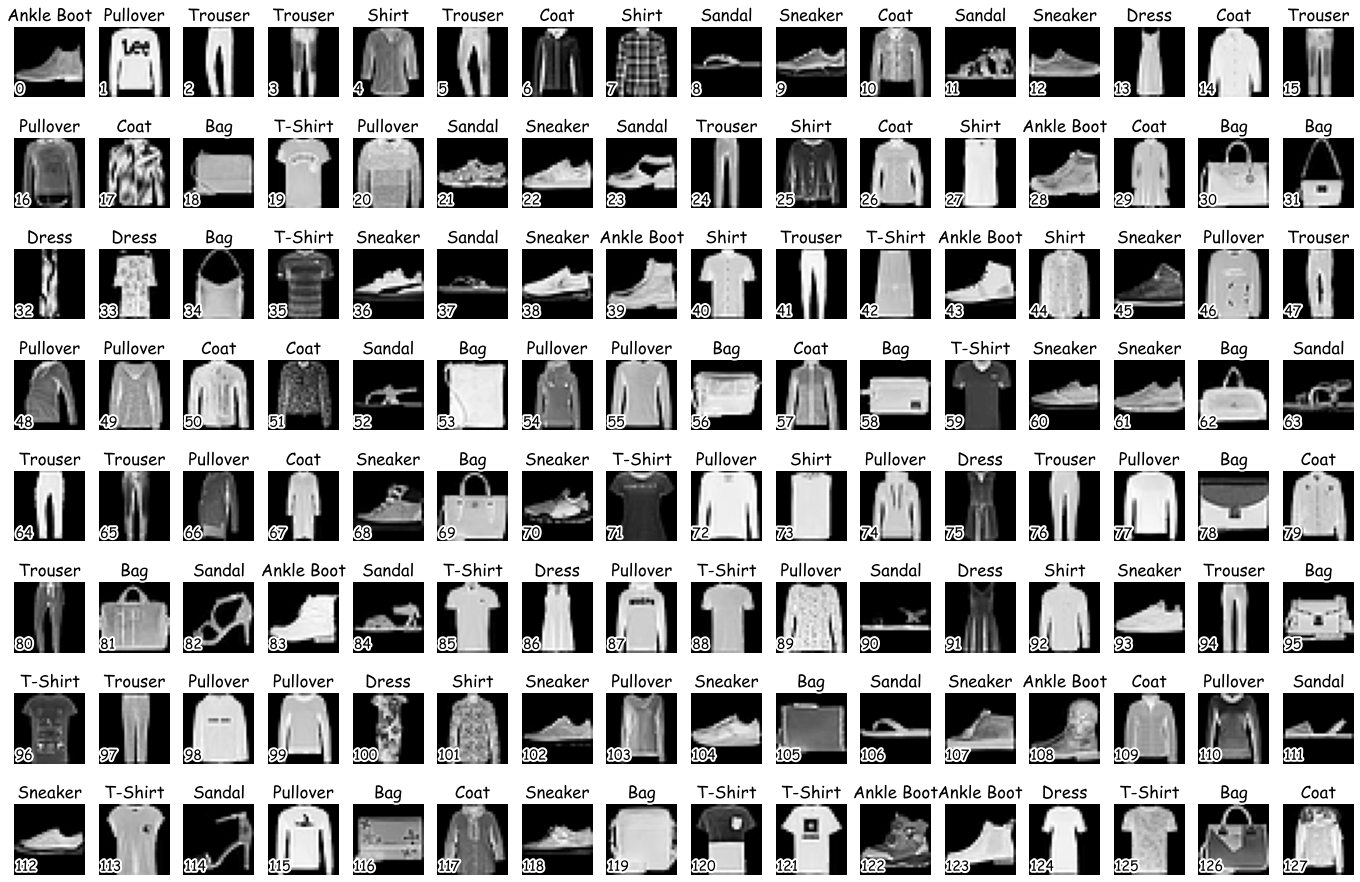

In [47]:
plt.figure(figsize=(24, 16))
for i in range(len(batch_X[0])): 
    plt.subplot(8, len(batch_X[0])/8, i+1)
    plt.axis('off')
    plt.imshow(batch_X[0][i].cpu().reshape(28, 28), cmap='gray')
    plt.text(0, 26,i)
    plt.title(classes[predicted_SVM_gen[0][i]])
#plt.savefig('fashion_mnist.png')
plt.show()

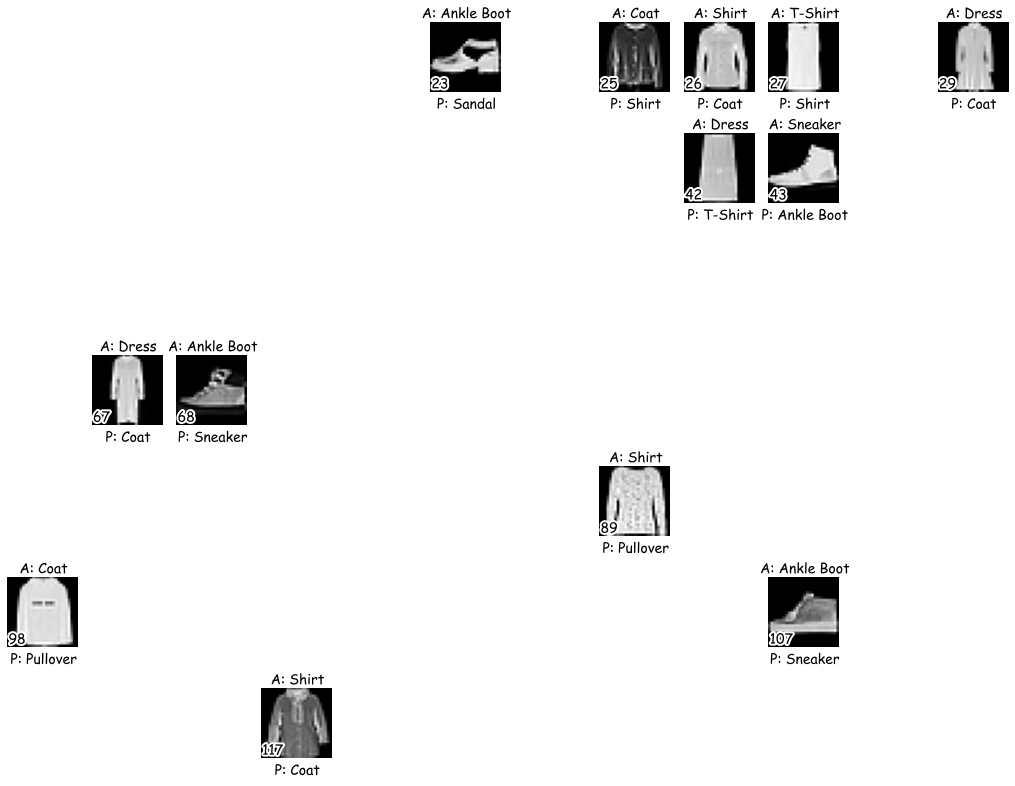

In [48]:
plt.figure(figsize=(24, 16))
for i in range(len(batch_X[0])): 
    if predicted_SVM_gen[0][i] !=batch_Y[0][i]:
        plt.subplot(8, len(batch_X[0])/8, i+1)
        plt.axis('off')
        plt.imshow(batch_X[0][i].cpu().reshape(28, 28), cmap='gray')
        plt.text(14, -2,'A: '+classes[batch_Y[0][i]], ha='center')
        plt.text(14, 34,'P: '+classes[predicted_SVM_gen[0][i]], ha='center')
        plt.text(0, 26,i)
    #plt.savefig('fashion_mnist.png')
plt.show()

CNN-SVM 또한, CNN-softmax가 잘 분류하지 못했던 것들에 대해 공통적으로 잘 분류하지 못하고 있음을 확인하였습니다.

### Prevent Overfitting

적절한 epoch에 대해서 이야기해보자면, 반복 학습을 할수록 training accuracy는 줄어들지만, train data에 overfitting되어 generalization error는 오히려 커질 수 있습니다. epoch=17에서 $\mathbf{w}^T\mathbf{w}$의 크기가 가장 작았는데 이는 margin이 가장 넓은 것을 의미하고, 이는 generalization error를 작게 합니다. 따라서 margin을 최대로 갖는 epoch=17로 다시 학습하여 test accuracy를 확인해보도록 하겠습니다. 

In [37]:
# CNN 모델 정의
model_SVM_gen_17 = CNN().to(device)

criterion = multiClassHingeLoss_gen().to(device)   
optimizer = torch.optim.Adam(model_SVM_gen_17.parameters(), lr=learning_rate)

total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 468


In [38]:
loss_in_each_epoch2 = []
wtw_in_each_epoch2 = []
for epoch in range(12):
    total_loss = 0
    total_wtw = 0
    for X, Y in train_loader: # mini batch 단위로 data 불러옴
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        output = model_SVM_gen_17(X)
        loss, wtw = criterion(output, Y, model_SVM_gen_17.fc2.weight.data)
        loss.backward()
        optimizer.step()
        
        
        total_loss += loss
        total_wtw += wtw.item()
        
    avg_loss = total_loss/total_batch
    loss_in_each_epoch2.append(avg_loss)
    avg_wtw = total_wtw/total_batch
    wtw_in_each_epoch2.append(avg_wtw)
    print('[Epoch: {:>4}] loss = {:>.9}, weight = {:>.9}'.format(epoch + 1, avg_loss, avg_wtw))

[Epoch:    1] loss = 40.7513809, weight = 19.7427594
[Epoch:    2] loss = 1.77625251, weight = 19.6844253
[Epoch:    3] loss = 1.05650425, weight = 19.6462954
[Epoch:    4] loss = 0.958565116, weight = 19.6216113
[Epoch:    5] loss = 0.909049511, weight = 19.5963528
[Epoch:    6] loss = 0.874807596, weight = 19.5243918
[Epoch:    7] loss = 0.839980185, weight = 19.4374373
[Epoch:    8] loss = 0.81908536, weight = 19.3711913
[Epoch:    9] loss = 0.822007895, weight = 19.2381917
[Epoch:   10] loss = 0.798603594, weight = 19.0643963
[Epoch:   11] loss = 0.78239733, weight = 18.8369314
[Epoch:   12] loss = 0.791720629, weight = 18.5770643


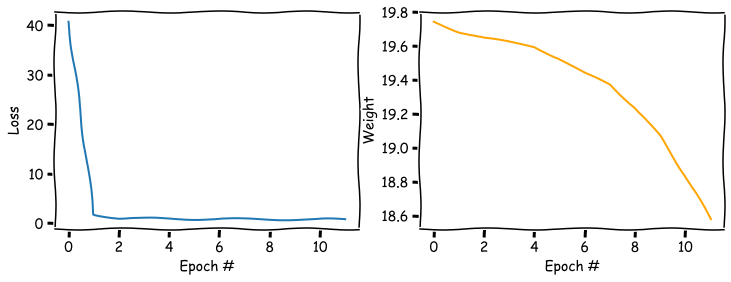

In [39]:
plt.xkcd()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(loss_in_each_epoch2)


plt.subplot(1, 2, 2)
plt.xlabel('Epoch #')
plt.ylabel('Weight')
plt.plot(wtw_in_each_epoch2, color='orange')
plt.show()

17회 반복 학습한 결과, weight는 더이상 발산하지 않지만 loss는 100번 수행한 결과보다 큰 값을 가지고 있습니다.   
하지만 test accuracy를 보면, 

In [42]:
with torch.no_grad():
    correct = 0
    total = 0
    batch_X = []
    batch_Y = []
    predicted_SVM_gen_17 = []
    
    for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        prediction = model_SVM_gen_17(X_test)
        predicted = torch.argmax(prediction, 1)
        total += Y_test.size(0)
        correct += (predicted == Y_test).sum().item()
        
        batch_X.append(X_test)
        batch_Y.append(Y_test)
        predicted_SVM_gen_17.append(predicted)

accuracy_SVM_gen_17 =100*correct/total
print('Test Accuracy of the model on the 10000 test images: {} %'.format(accuracy_SVM_gen_17))  

Test Accuracy of the model on the 10000 test images: 84.58533653846153 %


17번의 반복 수행만으로, epoch=100일 때의 test acurracy보다 높은 accuracy를 얻었습니다. 따라서 적절한 epoch을 결정해, overfitting을 방지했다고 할 수 있습니다.

### 2-2. Without $\mathbf{w}^T\mathbf{w}$ minimization
다음으로는 margin을 최소화 시키는 $\mathbf{w}^T\mathbf{w}$ term을 제외하고 오분류되는 정도만을 최소화 하여 update하는 model에 대해 추가적으로 실험해보았습니다.

In [31]:
class multiClassHingeLoss(nn.Module):
    def __init__(self):
        super(multiClassHingeLoss, self).__init__()
    
    def forward(self, output, y, fc):#output: batchsize*n_class
        #print(output.requires_grad) #True
        #print(y.requires_grad) #False
        
        output_y=output[torch.arange(0,y.size()[0]).long().cuda(),y.data.cuda()].view(-1,1)#view for transpose
        
        #margin - output[y] + output[i]
        loss=output-output_y+1#contains i=y

        
        #remove i=y items
        loss[torch.arange(0,y.size()[0]).long().cuda(),y.data.cuda()]=0
        
        #max(0,_)
        loss[loss<0]=0

        #L2-SVM
        loss=torch.pow(loss,2)

        # w^tw
        loss = torch.sum(loss)
        #loss += torch.pow(fc, 2).sum()
        loss/=output.size()[0]
        
        return loss, torch.pow(fc, 2).sum()

In [32]:
# CNN 모델 정의
model_SVM = CNN().to(device)

criterion = multiClassHingeLoss().to(device)   
optimizer = torch.optim.Adam(model_SVM.parameters(), lr=learning_rate)

total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 468


In [33]:
loss_in_each_epoch = []
wtw_in_each_epoch = []
for epoch in range(training_epochs):
    total_loss = 0
    total_wtw = 0
    for X, Y in train_loader: # mini batch 단위로 data 불러옴
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        #Y_one_hot = torch.zeros(batch_size, num_classes)
        #Y_one_hot[range(Y_one_hot.shape[0]), Y]=1
        #Y_one_hot[Y_one_hot == 0]=-1    

        optimizer.zero_grad()
        output = model_SVM(X)
        loss, wtw = criterion(output, Y, model_SVM.fc2.weight.data)
        loss.backward()
        optimizer.step()
        
        
        total_loss += loss
        total_wtw += wtw.item()
        
    avg_loss = total_loss/total_batch
    loss_in_each_epoch.append(avg_loss)
    avg_wtw = total_wtw/total_batch
    wtw_in_each_epoch.append(avg_wtw)
    print('[Epoch: {:>4}] loss = {:>.9}, weight = {:>.9}'.format(epoch + 1, avg_loss, avg_wtw))

[Epoch:    1] loss = 31.0848465, weight = 19.1810932
[Epoch:    2] loss = 0.846605062, weight = 19.1385909
[Epoch:    3] loss = 0.788474798, weight = 19.0692589
[Epoch:    4] loss = 0.765734434, weight = 18.9749078
[Epoch:    5] loss = 0.710426748, weight = 18.8589811
[Epoch:    6] loss = 0.700376511, weight = 18.755252
[Epoch:    7] loss = 0.684067726, weight = 18.5833708
[Epoch:    8] loss = 0.671886683, weight = 18.4442933
[Epoch:    9] loss = 0.660109282, weight = 18.2159754
[Epoch:   10] loss = 0.650318623, weight = 17.9647748
[Epoch:   11] loss = 0.629162073, weight = 17.7037937
[Epoch:   12] loss = 0.607582688, weight = 17.3630713
[Epoch:   13] loss = 0.602985263, weight = 16.9592919
[Epoch:   14] loss = 0.604841352, weight = 16.6505774
[Epoch:   15] loss = 0.582868516, weight = 16.1716695
[Epoch:   16] loss = 0.572639823, weight = 15.7837767
[Epoch:   17] loss = 0.583262682, weight = 15.3061506
[Epoch:   18] loss = 0.564474642, weight = 14.8270318
[Epoch:   19] loss = 0.5535343

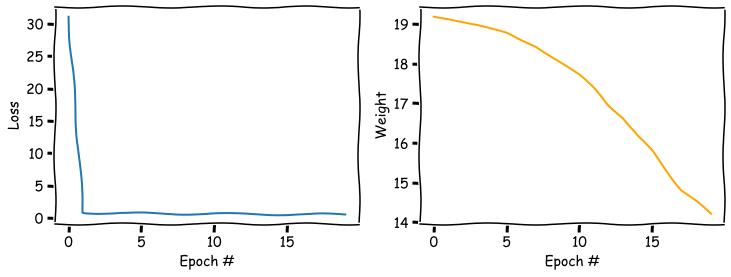

In [34]:
plt.xkcd()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(loss_in_each_epoch)


plt.subplot(1, 2, 2)
plt.xlabel('Epoch #')
plt.ylabel('Weight')
plt.plot(wtw_in_each_epoch, color='orange')
plt.show()

In [35]:
with torch.no_grad():
    correct = 0
    total = 0
    batch_X = []
    batch_Y = []
    predicted_SVM = []
    
    for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        prediction = model_SVM(X_test)
        predicted = torch.argmax(prediction, 1)
        total += Y_test.size(0)
        correct += (predicted == Y_test).sum().item()
        
        batch_X.append(X_test)
        batch_Y.append(Y_test)
        predicted_SVM.append(predicted)

accuracy_SVM_without_gen =100*correct/total
print('Test Accuracy of the model on the 10000 test images: {} %'.format(accuracy_SVM_without_gen))  

Test Accuracy of the model on the 10000 test images: 85.5869391025641 %


## Result

In [36]:
print("CNN-softmax: {:}% | CNN-SVM(epoch=100): {:}% | CNN-SVM(epoch=17): {:}%".format(accuracy_softmax,accuracy_SVM_gen, accuracy_SVM_gen_17))

CNN-softmax: 88.47155448717949% | CNN-SVM(epoch=100): 87.17948717948718% | CNN-SVM(epoch=17): 86.38822115384616%


실험 결과, 논문에서처럼 CNN-SVM model의 test accuracy는 CNN-softmax의 accuracy를 넘지 못했지만 크게 차이나지 정도의 accuracy를 보이고 있습니다. 또한 overfitting을 막기 위해 적절한 epoch만큼 학습한 model이 그렇지 않은 model보다 성능이 약간 더 좋음을 확인할 수 있었습니다. 따라서 반복 학습을 많이 하는 것이 무조건 좋은 성능을 보장해주지 않는 다는 것을 다시 한번 상기하게 되었습니다.

## 마치며, 

이번 시간에는 image classification에 있어서 보편적으로 사용되는 CNN-softmax model과 마지막 classifier를 SVM으로 바꾼 model을 구현하고, Fashion-MNIST dataset에 대한 classification 결과를 비교하여 보았습니다. CNN-SVM model이 softmax를 사용한 것보다 큰 성능 향상이 있진 않았지만, 당연하게 사용하던 softmax에 대해 대체 방법을 생각해보고, 이에 대한 성능 비교를 했다는 점에서 이 글의 의의를 찾을 수 있을 것 같습니다. 

또한 custom loss function을 만들어봄으로써, 앞으로 어떤 model에 대해 다양항 loss function을 적용시켜볼 수 있을 것이라 생각됩니다. 

제가 준비한 내용은 여기까지입니다. 
긴 글 읽어주셔서 감사합니다. 